In [1]:
!pip3 install tensorflow
!pip3 install kagglehub


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from tensorflow import keras
from keras import layers

c:\Users\victo\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\victo\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\victo\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framewo

In [3]:
file_path = os.path.join("wre.us.txt")
df = pd.read_csv(file_path)

# Extraer encabezados
header = df.columns.tolist()
price = df["Close"].to_numpy()             
raw_data = df.iloc[:, 1:].to_numpy() 


# Punto 1
## Parsing Data



In [4]:

price_high = df["High"].to_numpy()
price_low = df["Low"].to_numpy()
price = (price_high + price_low) / 2

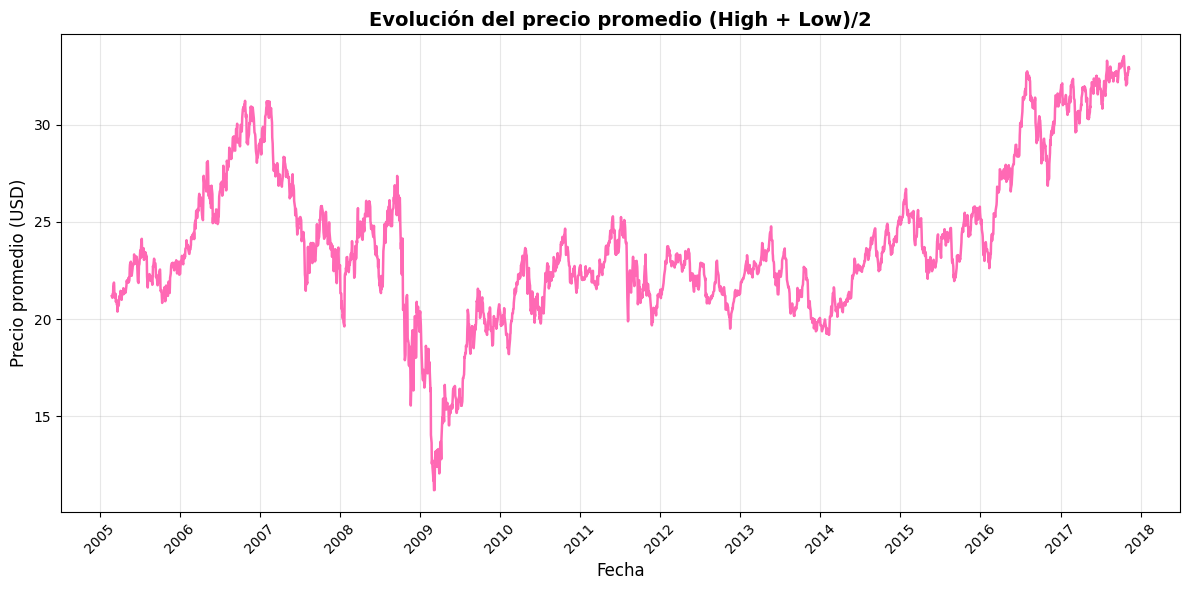

In [5]:


# Convertir la columna 'Date' a formato de fecha
df["Date"] = pd.to_datetime(df["Date"])

plt.figure(figsize=(12,6))
plt.plot(df["Date"], price, color='hotpink', linewidth=1.8)

# Título y etiquetas
plt.title("Evolución del precio promedio (High + Low)/2", fontsize=14, weight='bold')
plt.xlabel("Fecha", fontsize=12)
plt.ylabel("Precio promedio (USD)", fontsize=12)

# Formato del eje X para fechas
plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))       
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y")) 

# Rotar etiquetas y ajustar estilo
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# Normalization

In [6]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 1600
num_val_samples: 800
num_test_samples: 801


In [7]:
print("¿Hay NaN en raw_data?:", np.isnan(raw_data).any())
print("¿Hay inf en raw_data?:", np.isinf(raw_data).any())
std = raw_data[:num_train_samples].std(axis=0)
print("Mínimo std:", np.min(std))

¿Hay NaN en raw_data?: False
¿Hay inf en raw_data?: False
Mínimo std: 0.0


In [8]:

mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)

# Verificar columnas con std = 0
constant_cols = np.where(std == 0)[0]
column_names = df.columns[1:]
print("Columnas constantes:", column_names[constant_cols])
print("Número de columnas constantes:", len(constant_cols))

std[std == 0] = 1 
raw_data /= std


Columnas constantes: Index(['OpenInt'], dtype='object')
Número de columnas constantes: 1


### Clase Redes

In [9]:


class ModelBuilder:
    def __init__(self, raw_data, price, sequence_length):
        self.raw_data = raw_data
        self.price = price
        self.sequence_length = sequence_length
        self.models = {}
        self.histories = {}
        self.train_dataset = None
        self.val_dataset = None
        self.test_dataset = None

 
    def create_datasets(self, delay, batch_size, sampling_rate, num_train_samples, num_val_samples):
        self.train_dataset = keras.utils.timeseries_dataset_from_array(
            data=self.raw_data[:-delay],
            targets=self.price[delay:],
            sequence_length=self.sequence_length,
            sampling_rate=sampling_rate,
            shuffle=False,
            batch_size=batch_size,
            start_index=0,
            end_index=num_train_samples
        )

        self.val_dataset = keras.utils.timeseries_dataset_from_array(
            data=self.raw_data[:-delay],
            targets=self.price[delay:],
            sequence_length=self.sequence_length,
            sampling_rate=sampling_rate,
            shuffle=False,
            batch_size=batch_size,
            start_index=num_train_samples,
            end_index=num_train_samples + num_val_samples
        )

        self.test_dataset = keras.utils.timeseries_dataset_from_array(
            data=self.raw_data[:-delay],
            targets=self.price[delay:],
            sequence_length=self.sequence_length,
            sampling_rate=sampling_rate,
            shuffle=False,
            batch_size=batch_size,
            start_index=num_train_samples + num_val_samples
        )

        return self.train_dataset, self.val_dataset, self.test_dataset

   
    def create_LSTM_model(self, num_neurons, epochs, dropout_rate=0.0, use_recurrent_dropout=False, name_model="LSTM"):
        inputs = keras.Input(shape=(self.sequence_length, self.raw_data.shape[-1]))
        x = layers.LSTM(num_neurons, recurrent_dropout=dropout_rate if use_recurrent_dropout else 0)(inputs)
        outputs = layers.Dense(1)(x)
        model = keras.Model(inputs, outputs)

        callbacks = [keras.callbacks.ModelCheckpoint(f"{name_model}.keras", save_best_only=True)]
        model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
        history = model.fit(self.train_dataset, epochs=epochs, validation_data=self.val_dataset, callbacks=callbacks)

        model = keras.models.load_model(f"{name_model}.keras")
        print(f"Test MAE: {model.evaluate(self.test_dataset)[1]:.2f}")
        self.models[name_model] = model
        self.histories[name_model] = history
        return model, history

 
    def create_GRU_model(self, num_neurons, epochs, dropout_rate=0.0, use_recurrent_dropout=False, name_model="GRU"):
        inputs = keras.Input(shape=(self.sequence_length, self.raw_data.shape[-1]))
        x = layers.GRU(num_neurons, recurrent_dropout=dropout_rate if use_recurrent_dropout else 0)(inputs)
        outputs = layers.Dense(1)(x)
        model = keras.Model(inputs, outputs)

        callbacks = [keras.callbacks.ModelCheckpoint(f"{name_model}.keras", save_best_only=True)]
        model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
        history = model.fit(self.train_dataset, epochs=epochs, validation_data=self.val_dataset, callbacks=callbacks)

        model = keras.models.load_model(f"{name_model}.keras")
        print(f"Test MAE: {model.evaluate(self.test_dataset)[1]:.2f}")
        self.models[name_model] = model
        self.histories[name_model] = history
        return model, history

  
    def create_stacked_GRU(self, num_l1, num_l2, epochs, name_model="Stacked_GRU"):
        num_features = self.raw_data.shape[-1]
        output_dim = 1

        model = tf.keras.Sequential([
            tf.keras.layers.GRU(num_l1, return_sequences=True, input_shape=(self.sequence_length, num_features)),
            tf.keras.layers.GRU(num_l2, return_sequences=False),
            tf.keras.layers.Dense(output_dim, activation='linear')
        ])

        callbacks = [keras.callbacks.ModelCheckpoint(f"{name_model}.keras", save_best_only=True)]
        model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
        history = model.fit(self.train_dataset, epochs=epochs, validation_data=self.val_dataset, callbacks=callbacks)

        model = keras.models.load_model(f"{name_model}.keras")
        print(f"Test MAE: {model.evaluate(self.test_dataset)[1]:.2f}")
        self.models[name_model] = model
        self.histories[name_model] = history
        return model, history
    
    
    def graph_history(self,history):
        loss = history.history["mae"]
        val_loss = history.history["val_mae"]
        epochs = range(1, len(loss) + 1)
        plt.figure()
        plt.plot(epochs, loss, "lightpink", label="Training MAE")
        plt.plot(epochs, val_loss, "purple", label="Validation MAE")
        plt.title("Training and validation MAE (LSTM)")
        plt.legend()
        plt.show()
        
        
    
    def graph_prediction(self,y_true, predictions):
        # Plotting
        plt.figure(figsize=(10, 5))
        plt.plot(y_true[20:40], label='True Values', color='pink')
        plt.plot(predictions[20:40], label='Predicted Values', color='purple')
        plt.title('LSTM Predictions vs True Values')
        plt.xlabel('Date')
        plt.ylabel('Value')
        plt.legend()
        plt.show()


 
    def predict(self, model):
        
        if model is None:
            raise ValueError(f"Modelo {model} no existe.")
        
        y_true = np.concatenate([y for x, y in self.test_dataset], axis=0)
        predictions = model.predict(self.test_dataset)
        return y_true, predictions

   



# Punto 2

In [10]:
builder = ModelBuilder(raw_data, price, sequence_length=30)

# Crear datasets
builder.create_datasets(delay=1, batch_size=32, sampling_rate=1,
                        num_train_samples=num_train_samples,
                        num_val_samples=num_val_samples)


(<_BatchDataset element_spec=(TensorSpec(shape=(None, None, 6), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_BatchDataset element_spec=(TensorSpec(shape=(None, None, 6), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_BatchDataset element_spec=(TensorSpec(shape=(None, None, 6), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [11]:
model_lstm, hist_lstm = builder.create_LSTM_model(num_neurons=64, epochs=100,
                                                  dropout_rate=0.2, use_recurrent_dropout=True,
                                                  name_model="LSTM_64")




Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 333.7988 - mae: 17.7046 - val_loss: 133.6906 - val_mae: 11.5007
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 131.2056 - mae: 10.6972 - val_loss: 63.8838 - val_mae: 7.9013
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 71.3024 - mae: 7.5873 - val_loss: 26.6052 - val_mae: 5.0145
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 37.7604 - mae: 5.2808 - val_loss: 7.8025 - val_mae: 2.5212
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 19.3826 - mae: 3.5283 - val_loss: 1.7490 - val_mae: 1.0807
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 10.6189 - mae: 2.3832 - val_loss: 1.9760 - val_mae: 1.1246
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.7562 - mae: 2.0329 - val_loss: 2.3475 - val_mae: 1.2796
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 6.2421 - mae: 1.8393 - val_loss: 1.4255 - val_mae: 1.0044
Epoch 9/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s

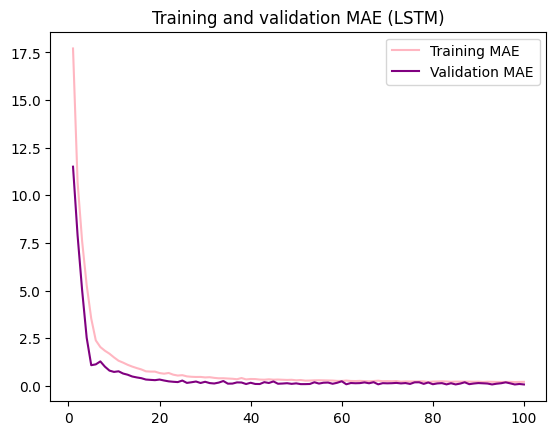

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


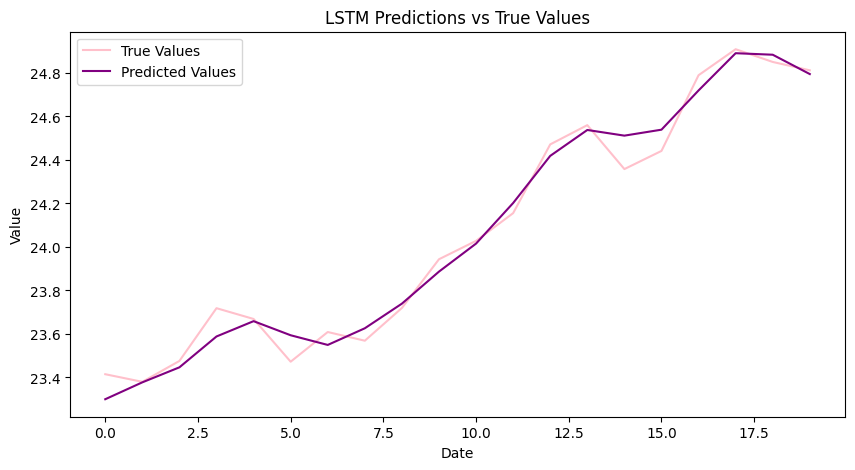

In [12]:
builder.graph_history(hist_lstm)
y_true,predictions = builder.predict(model_lstm)
builder.graph_prediction(y_true,predictions)


# Punto 3

In [13]:
model_gru, hist_gru = builder.create_GRU_model(num_neurons=32, epochs=100,
                                               dropout_rate=0.2, use_recurrent_dropout=True,
                                               name_model="GRU_32")

Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 477.1477 - mae: 21.6515 - val_loss: 272.5687 - val_mae: 16.4738
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 277.1048 - mae: 16.3129 - val_loss: 162.9886 - val_mae: 12.7105
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 191.9093 - mae: 13.3695 - val_loss: 121.8132 - val_mae: 10.9707
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 141.6907 - mae: 11.2690 - val_loss: 89.3569 - val_mae: 9.3752
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 107.8128 - mae: 9.6642 - val_loss: 62.6871 - val_mae: 7.8245
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 80.4220 - mae: 8.1901 - val_loss: 41.6099 - val_mae: 6.3360
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 58.8522 - mae: 6.8615 - val_loss: 25.6364 - val_mae: 4.9164
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 42.0819 - mae: 5.6752 - val_loss: 14.3547 - val_mae: 3.5902
Epoch 9/100
50/50 ━━━━━━━━━━━━━━

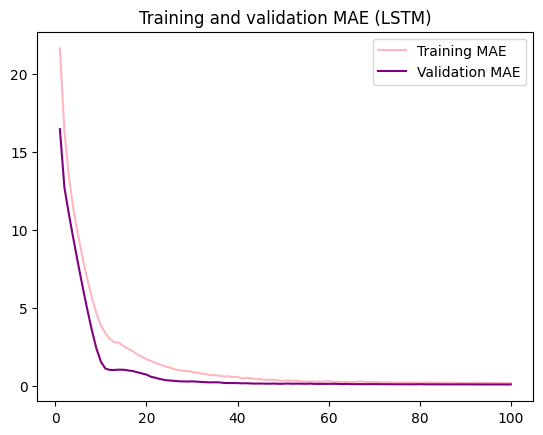

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


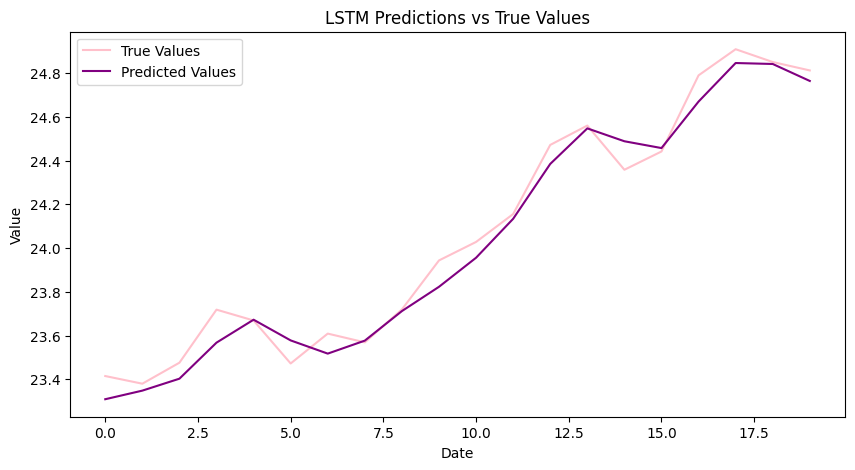

In [14]:
builder.graph_history(hist_gru)
y_trueG,predictionsG = builder.predict(model_gru)
builder.graph_prediction(y_trueG,predictionsG)


# Punto 4

In [15]:
model_stack, hist_stack = builder.create_stacked_GRU(num_l1=64, num_l2=32, epochs=50,
                                                     name_model="Stacked_GRU")

Epoch 1/50


c:\Users\victo\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 370.4836 - mae: 18.8124 - val_loss: 184.8020 - val_mae: 13.5402
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 209.8980 - mae: 13.9441 - val_loss: 141.6276 - val_mae: 11.8390
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 160.9167 - mae: 12.0713 - val_loss: 106.8135 - val_mae: 10.2639
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 125.5886 - mae: 10.5181 - val_loss: 77.6307 - val_mae: 8.7273
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 95.7812 - mae: 9.0462 - val_loss: 53.6666 - val_mae: 7.2250
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 71.1680 - mae: 7.6371 - val_loss: 34.7521 - val_mae: 5.7695
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 51.6041 - mae: 6.3752 - val_loss: 20.6873 - val_mae: 4.3843
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 36.8832 - mae: 5.2554 - val_loss: 11.1164 - val_mae: 3.1066
Epoch 9/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms

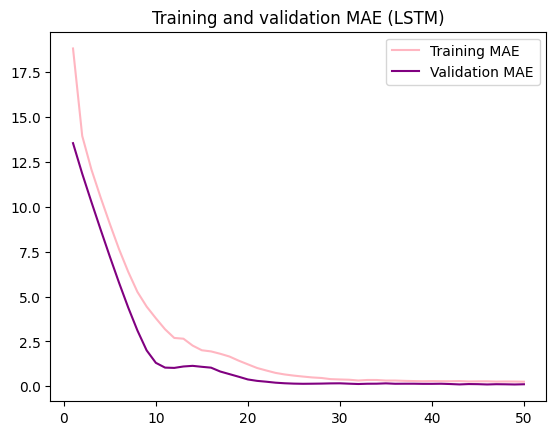

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


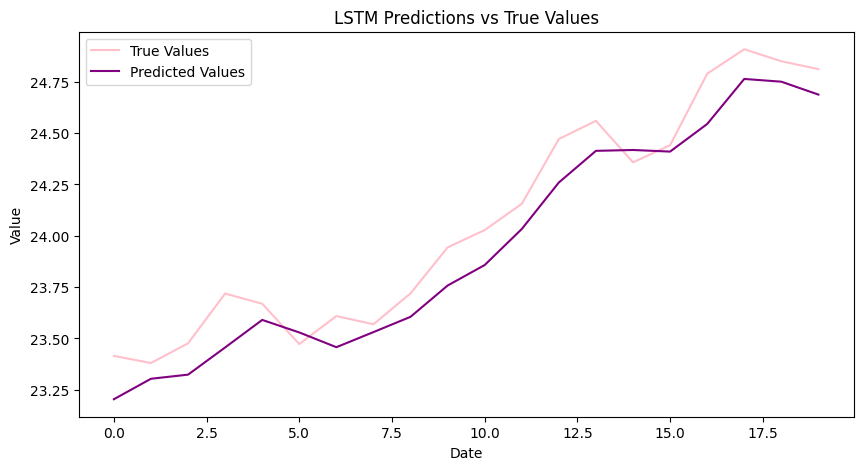

In [16]:
builder.graph_history(hist_stack)
y_trueS,predictionsS = builder.predict(model_stack)
builder.graph_prediction(y_trueS,predictionsS)
